# Project 3

In [1]:
# Library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import solvers, matrix

#### Q1

In [2]:
def plot_heat_map(heat_array, title):
    min_value = np.min(heat_array)
    max_value = np.max(heat_array)
    plt.pcolor(heat_array, cmap='hot',vmin=min_value, vmax=max_value)
    plt.ylim(top=0, bottom=10)
    plt.xlim(left=0, right=10)
    plt.colorbar()
    plt.title(title)
    plt.show()

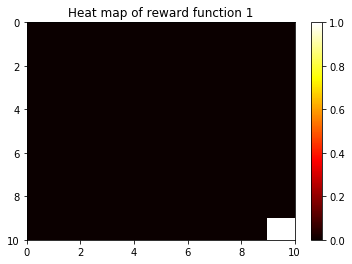

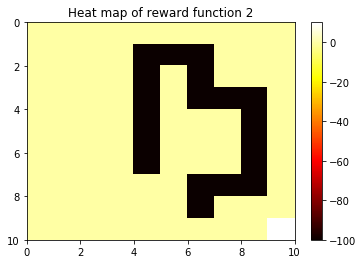

In [3]:
# Reward function 1
reward_1 = np.zeros((10, 10))
reward_1[9, 9] = 1
plot_heat_map(reward_1, 'Heat map of reward function 1')

# Reward function 1
reward_2 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0, 0, -100, -100, -100, 0, 0, 0], 
                     [0, 0, 0, 0, -100, 0, -100, 0, 0, 0], 
                     [0, 0, 0, 0, -100, 0, -100, -100, -100, 0], 
                     [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                     [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                     [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                     [0, 0, 0, 0, 0, 0, -100, -100, -100, 0], 
                     [0, 0, 0, 0, 0, 0, -100, 0, 0, 0], 
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]])
plot_heat_map(reward_2,  'Heat map of reward function 2')

#### Q2 & Q3 & Q5

In [4]:
# Environment setup
state_space = np.tile(np.arange(0, 100, 10), (10, 1)) + np.arange(0, 10, 1).reshape((10, 1))
discount_factor = 0.8
random_probability = 0.1
cur_reward = reward_1
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
all_actions = [UP, DOWN, LEFT, RIGHT]


In [5]:
def state_to_coordinate(state, state_sets=state_space):
    y, x = np.where(state_sets == state)
    return (x[0], y[0])

def coordinate_to_state(coordinate_x, coordinate_y, state_sets=state_space):
    return state_sets[coordinate_y, coordinate_x]

def get_valid_actions(state):
    valid_actions = all_actions.copy()
    x, y = state_to_coordinate(state)
    if x == 0:
        valid_actions.remove(LEFT)
    elif x == 9:
        valid_actions.remove(RIGHT)
    if y == 0:
        valid_actions.remove(UP)
    elif y == 9:
        valid_actions.remove(DOWN)
    return valid_actions

def get_next_states_probabilities(cur_state, cur_action):
    cur_valid_actions = get_valid_actions(cur_state)
    next_probabilities = [0] * 5 # Order UP, DOWN, LEFT, RIGHT, STAY
    for action in cur_valid_actions: # w/4 for states inside the grid
            next_probabilities[action] = random_probability / 4
    
    # Calculate the transition probabilities for an action
    if (len(cur_valid_actions) == 4): # No boundary cases
        next_probabilities[cur_action] += 1 - random_probability
        next_probabilities[4] = 0 # Probability to state in the current state is 0
    
    else: # With probability to move out the grid
        next_probabilities[4] = random_probability * (1 - len(cur_valid_actions) / 4)
        if cur_action in cur_valid_actions:
            next_probabilities[cur_action] += 1 - random_probability
        else:
            next_probabilities[4] += 1 - random_probability
    
    return next_probabilities

def state_reward(state, reward_function):
    x, y = state_to_coordinate(state)
    return reward_function[y, x]

def get_state_value_function(reward_function):
    # Initialize
    state_value_function = np.zeros((10, 10))
    delta = 1 # Exit flag

    while delta > 0.01:
        delta = 0 
        previous_state_value_function = state_value_function.copy()
        # Loop over 100 states
        for cur_state in range(100): 
            cur_x, cur_y = state_to_coordinate(cur_state)
            previous_state_value = previous_state_value_function[cur_y, cur_x]
            state_value_all_actions = [0] * 4

            # Loop over all actions
            for cur_action in all_actions:
                transition_probabilities = get_next_states_probabilities(cur_state, cur_action) 

                # Sum over one action
                for prob_idx in range(len(transition_probabilities)):
                    prob = transition_probabilities[prob_idx]
                    if (prob != 0): # Remove invalid case
                        # Next state coordinate
                        next_x = cur_x
                        next_y = cur_y
                        if prob_idx == 0: # Move up
                            next_y -= 1
                        elif prob_idx == 1: # Move down
                            next_y += 1
                        elif prob_idx == 2: # Move left
                            next_x -= 1
                        elif prob_idx == 3: # Move right
                            next_x += 1
                        else: # Stay in the state
                            pass
                        next_state = coordinate_to_state(next_x, next_y)
                        state_value_all_actions[cur_action] += prob * (state_reward(next_state, reward_function) + discount_factor * previous_state_value_function[next_y, next_x])

            cur_state_value = max(state_value_all_actions)
            state_value_function[cur_y, cur_x] = cur_state_value
            delta = max(delta, abs(previous_state_value - cur_state_value)) 
    return state_value_function

def get_optimal_policy_function(state_value_function, reward_function):
    # Initialize
    optimal_policy_function = np.zeros((10, 10))

    # Loop all states
    for cur_state in range(100):  
        cur_x, cur_y = state_to_coordinate(cur_state)
        state_value_all_actions = [0] * 4

        # Loop over all actions
        for cur_action in all_actions:
            transition_probabilities = get_next_states_probabilities(cur_state, cur_action) 

            # Sum over one action
            for prob_idx in range(len(transition_probabilities)):
                prob = transition_probabilities[prob_idx]
                if (prob != 0): # Remove invalid case
                    # Next state coordinate
                    next_x = cur_x
                    next_y = cur_y
                    if prob_idx == 0: # Move up
                        next_y -= 1
                    elif prob_idx == 1: # Move down
                        next_y += 1
                    elif prob_idx == 2: # Move left
                        next_x -= 1
                    elif prob_idx == 3: # Move right
                        next_x += 1
                    else: # Stay in the state
                        pass
                    next_state = coordinate_to_state(next_x, next_y)
                    state_value_all_actions[cur_action] += prob * (state_reward(next_state, reward_function) + discount_factor * state_value_function[next_y, next_x])
        
        #state_value_all_actions = np.around(state_value_all_actions, 3) # Round the value to 5 dicimal5
        optimal_action = np.argmax(state_value_all_actions)
        optimal_policy_function[cur_y, cur_x] = optimal_action
        #print('State: ', cur_state)
        #print(state_value_all_actions)
    return optimal_policy_function.astype(int)

def print_optimal_policy_with_arrows(optimal_policy_function):
    optimal_policy_symbols = np.chararray((10, 10), unicode=True)
    arrow_symbols = ['⇧','⇩','⇦','⇨']
#     arrow_symbols = ['↑ ','↓ ','←','→ ']
#     arrow_symbols = ['\21E1','\u21E3','\u21E0','\u21E2']
    for i in range(4):
        optimal_policy_symbols[optimal_policy_function == i] = arrow_symbols[i]
    print(pd.DataFrame(optimal_policy_symbols))


Optimal value of states: 
       0      1      2      3      4      5      6      7      8      9
0  0.044  0.065  0.091  0.125  0.168  0.223  0.292  0.380  0.491  0.610
1  0.065  0.088  0.122  0.165  0.219  0.289  0.378  0.491  0.633  0.788
2  0.091  0.122  0.165  0.219  0.289  0.378  0.491  0.636  0.818  1.019
3  0.125  0.165  0.219  0.289  0.378  0.491  0.636  0.820  1.052  1.315
4  0.168  0.219  0.289  0.378  0.491  0.636  0.820  1.054  1.352  1.695
5  0.223  0.289  0.378  0.491  0.636  0.820  1.054  1.353  1.733  2.182
6  0.292  0.378  0.491  0.636  0.820  1.054  1.354  1.735  2.220  2.807
7  0.380  0.491  0.636  0.820  1.054  1.353  1.735  2.220  2.839  3.608
8  0.491  0.633  0.818  1.052  1.352  1.733  2.220  2.839  3.629  4.635
9  0.610  0.788  1.019  1.315  1.695  2.182  2.807  3.608  4.635  4.702


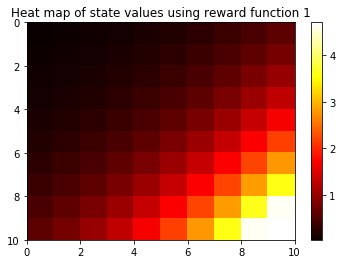

Optimal policy using arrows: 
   0  1  2  3  4  5  6  7  8  9
0  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩
1  ⇩  ⇩  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩
2  ⇩  ⇩  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
3  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
4  ⇩  ⇩  ⇩  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
5  ⇩  ⇩  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
6  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩
7  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩


In [6]:
state_value_function_1 = get_state_value_function(reward_1)
print('Optimal value of states: ')
pd.set_option('precision', 3)
print(pd.DataFrame(state_value_function_1))
plot_heat_map(state_value_function_1, 'Heat map of state values using reward function 1')
optimal_policy_function_1 = get_optimal_policy_function(state_value_function_1, reward_1)
print('Optimal policy using arrows: ')
print_optimal_policy_with_arrows(optimal_policy_function_1)

#### Q6 & Q7 & Q9

Optimal value of states: 
       0      1      2       3       4       5       6       7       8       9
0  0.647  0.791  0.821   0.525  -2.386  -4.237  -1.923   1.128   1.591   2.035
1  0.828  1.018  1.062  -1.879  -6.755  -8.684  -6.373  -1.298   1.925   2.607
2  1.061  1.313  1.446  -1.635  -6.758 -13.917  -9.653  -5.515  -0.135   3.355
3  1.358  1.689  1.944  -1.243  -6.339  -7.983  -7.947  -9.434  -1.918   4.387
4  1.734  2.168  2.586  -0.736  -5.847  -3.258  -3.241  -7.434   1.715   9.160
5  2.211  2.778  3.413  -0.038  -5.114  -0.553  -0.488  -2.984   6.583  15.354
6  2.816  3.553  4.479   3.024   2.480   2.880  -0.466  -4.911  12.688  23.296
7  3.584  4.539  5.793   7.288   6.719   7.241   0.931  12.366  21.159  33.483
8  4.558  5.795  7.397   9.439  12.008  12.889  17.097  23.014  33.778  46.529
9  5.727  7.316  9.388  12.045  15.452  19.824  25.498  36.158  46.583  47.311


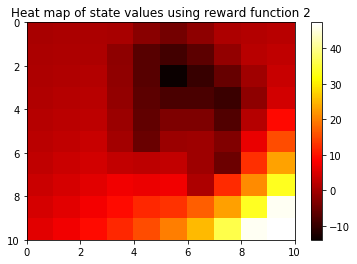

Optimal policy using arrows: 
   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⇧  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇧  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇩  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇦  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇩
7  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩


In [7]:
state_value_function_2 = get_state_value_function(reward_2)
print('Optimal value of states: ')
pd.set_option('precision', 3)
print(pd.DataFrame(state_value_function_2))
plot_heat_map(state_value_function_2, 'Heat map of state values using reward function 2')
optimal_policy_function_2 = get_optimal_policy_function(state_value_function_2, reward_2)
print('Optimal policy using arrows: ')
print_optimal_policy_with_arrows(optimal_policy_function_2)

#### Q11 & Q12 & Q13 & Q14 & Q16

In [8]:
def get_neighbor_states(state):
    x, y = state_to_coordinate(state)
    valid_actions = get_valid_actions(state)
    neighbor_states = [-1] * 5 # -1 for out the grid
    neighbor_states[4] = state # Original state
    for action in valid_actions:
        neighbor_x = x
        neighbor_y = y
        if action == 0: # Move up
            neighbor_y -= 1
        elif action == 1: # Move down
            neighbor_y += 1
        elif action == 2: # Move left
            neighbor_x -= 1
        else: # Move right
            neighbor_x += 1
        neighbor_states[action] = coordinate_to_state(neighbor_x, neighbor_y)
    return neighbor_states

def get_transition_matrix(policy):
    transition_matrix = np.zeros((100, 100))
    for cur_state in range(100):
        x, y = state_to_coordinate(cur_state)
        neighbor_states = get_neighbor_states(cur_state)
        cur_action = policy[y, x]
        neighbor_states_probabilities = get_next_states_probabilities(cur_state, cur_action)
        for i in range(len(neighbor_states)):
            if neighbor_states_probabilities[i] != 0:
                transition_matrix[cur_state][neighbor_states[i]] = neighbor_states_probabilities[i]
    return transition_matrix

def get_transition_matrix_row(state, action):
    transition_matrix_row =  np.zeros((1, 100))
    x, y = state_to_coordinate(state)
    neighbor_states = get_neighbor_states(state)
    neighbor_states_probabilities = get_next_states_probabilities(state, action)
    for i in range(len(neighbor_states)):
        if neighbor_states_probabilities[i] != 0:
            transition_matrix_row[0][neighbor_states[i]] = neighbor_states_probabilities[i]
    return transition_matrix_row

def get_accuracy(IRL_policy, true_policy):
    return np.sum(IRL_policy == true_policy) / 100

In [13]:
%%capture

cur_reward = reward_1
cur_optimal_policy = optimal_policy_function_1

transition_matrix = get_transition_matrix(cur_optimal_policy)
I_minus_gamma_Pa_inverse = np.linalg.inv(np.identity(100) - discount_factor * transition_matrix)
Rmax = np.amax(np.abs(cur_reward))

# Construct D matrix
all_difference_dot_inverse = list()
for state in range(100):
    x, y = state_to_coordinate(state)
    optimal_action = cur_optimal_policy[y, x]
    for action in all_actions:
        if (action != optimal_action):
            difference = (-1) * (get_transition_matrix_row(state, optimal_action) - get_transition_matrix_row(state, action))
            transition_matrix = get_transition_matrix((np.ones((10,10))*optimal_action).astype(int))
            I_minus_gamma_Pa_inverse = np.linalg.inv(np.identity(100) - discount_factor * transition_matrix)
            all_difference_dot_inverse.append(difference.dot(I_minus_gamma_Pa_inverse))

block_1 = np.concatenate(all_difference_dot_inverse)

part_1 = np.concatenate((block_1, np.repeat(np.identity(100), [3] * 100, axis=0), np.zeros((300, 100))), axis=1)
part_2 = np.concatenate((block_1, np.zeros((300, 200))), axis=1)
part_3 = np.concatenate((-np.identity(100), np.zeros((100, 100)), -np.identity(100)), axis=1)
part_4 = np.concatenate((np.identity(100), np.zeros((100, 100)), -np.identity(100)), axis=1)
part_5 = np.concatenate((-np.identity(100), np.zeros((100, 200))), axis=1)
part_6 = np.concatenate((np.identity(100), np.zeros((100, 200))), axis=1)

# D matrix
D = np.concatenate((part_1, part_2, part_3, part_4, part_5, part_6))
G = matrix(D)
h = matrix(np.concatenate((np.zeros(800), Rmax * np.ones(200))))

# All accuracies
all_acc = list()
IRL_best_penalty = 0
IRL_best_reward = 0
IRL_optimal_state_values = 0
IRL_optimal_policy = 0

# Solve LP with muptiple penalty factors
for penalty_factor in np.arange(0, 5.01, 0.01):
    c = matrix(-np.concatenate((np.zeros(100), np.ones(100), np.ones(100) * (-penalty_factor))))
    sol = solvers.lp(c, G, h)
    IRL_reward = np.array(sol['x'][0:100]).reshape(10, 10).T
    IRL_reward = (IRL_reward - np.amin(IRL_reward)) / (np.amax(IRL_reward) - np.amin(IRL_reward))
    IRL_state_values = get_state_value_function(IRL_reward)
    IRL_policy = get_optimal_policy_function(IRL_state_values, IRL_reward)
    accuracy = get_accuracy(IRL_policy, cur_optimal_policy)
    # Store the best results
    if (len(all_acc) == 0 or accuracy > max(all_acc)):
        IRL_best_penalty = penalty_factor
        IRL_best_reward = IRL_reward
        IRL_optimal_state_values = IRL_state_values
        IRL_optimal_policy = IRL_policy
    all_acc.append(accuracy)

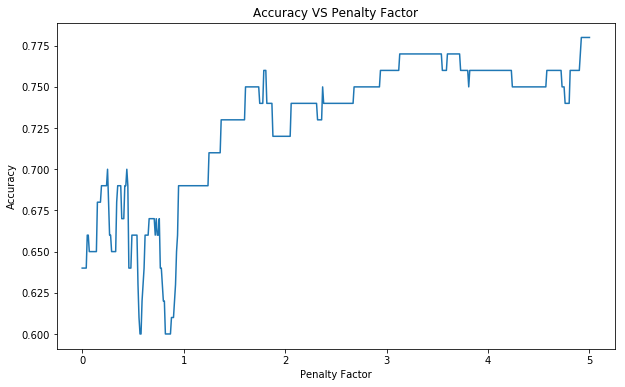

Penalty factor with best accuracy:  4.92
Corresponding accuracy:  0.78


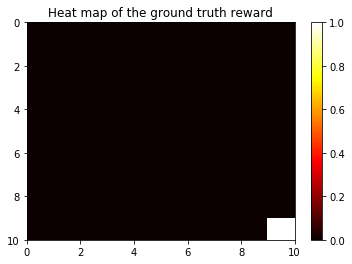

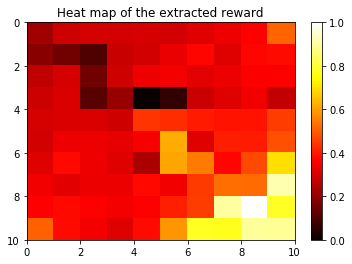

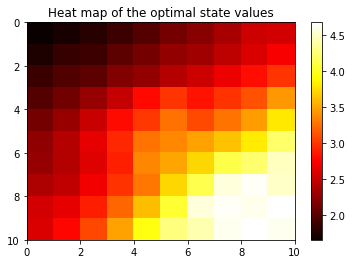

   0  1  2  3  4  5  6  7  8  9
0  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
2  ⇨  ⇩  ⇨  ⇩  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
3  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
4  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇨  ⇩
5  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
6  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇨  ⇩
7  ⇩  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩
8  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇦
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇧  ⇦


In [14]:
# plot the accuracy and penalty
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 5.01, 0.01), all_acc)
plt.xlabel('Penalty Factor')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Penalty Factor')
plt.show()

print('Penalty factor with best accuracy: ', IRL_best_penalty)
print('Corresponding accuracy: ', np.max(all_acc))
plot_heat_map(cur_reward, 'Heat map of the ground truth reward')
plot_heat_map(IRL_best_reward, 'Heat map of the extracted reward')
plot_heat_map(IRL_optimal_state_values, 'Heat map of the optimal state values')
print_optimal_policy_with_arrows(IRL_optimal_policy)

#### Q18 & Q19 & Q20 & Q21 & Q23

In [19]:
%%capture

cur_reward = reward_2
cur_optimal_policy = optimal_policy_function_2

transition_matrix = get_transition_matrix(cur_optimal_policy)
I_minus_gamma_Pa_inverse = np.linalg.inv(np.identity(100) - discount_factor * transition_matrix)
Rmax = np.max(np.abs(cur_reward))

# Construct D matrix
all_difference_dot_inverse = list()
for state in range(100):
    x, y = state_to_coordinate(state)
    optimal_action = cur_optimal_policy[y, x]
    for action in all_actions:
        if (action != optimal_action):
            difference = (-1) * (get_transition_matrix_row(state, optimal_action) - get_transition_matrix_row(state, action))
            transition_matrix = get_transition_matrix((np.ones((10,10))*optimal_action).astype(int))
            I_minus_gamma_Pa_inverse = np.linalg.inv(np.identity(100) - discount_factor * transition_matrix)
            all_difference_dot_inverse.append(difference.dot(I_minus_gamma_Pa_inverse))

block_1 = np.concatenate(all_difference_dot_inverse)

part_1 = np.concatenate((block_1, np.repeat(np.identity(100), [3] * 100, axis=0), np.zeros((300, 100))), axis=1)
part_2 = np.concatenate((block_1, np.zeros((300, 200))), axis=1)
part_3 = np.concatenate((-np.identity(100), np.zeros((100, 100)), -np.identity(100)), axis=1)
part_4 = np.concatenate((np.identity(100), np.zeros((100, 100)), -np.identity(100)), axis=1)
part_5 = np.concatenate((-np.identity(100), np.zeros((100, 200))), axis=1)
part_6 = np.concatenate((np.identity(100), np.zeros((100, 200))), axis=1)

# D matrix
D = np.concatenate((part_1, part_2, part_3, part_4, part_5, part_6))
G = matrix(D)
h = matrix(np.concatenate((np.zeros(800), Rmax * np.ones(200))))

# All accuracies
all_acc = list()
IRL_best_penalty = 0
IRL_best_reward = 0
IRL_optimal_state_values = 0
IRL_optimal_policy = 0

# Solve LP with muptiple penalty factors
for penalty_factor in np.arange(0, 5.01, 0.01):
    c = matrix(-np.concatenate((np.zeros(100), np.ones(100), np.ones(100) * (-penalty_factor))))
    sol = solvers.lp(c, G, h)
    IRL_reward = np.array(sol['x'][0:100]).reshape(10, 10).T
    IRL_reward = (IRL_reward - np.amin(IRL_reward)) / (np.amax(IRL_reward) - np.amin(IRL_reward)) *110

    IRL_state_values = get_state_value_function(IRL_reward)
    
    IRL_policy = get_optimal_policy_function(IRL_state_values, IRL_reward)
    accuracy = get_accuracy(IRL_policy, cur_optimal_policy)
    # Store the best results
    if (len(all_acc) == 0 or accuracy > max(all_acc)):
        IRL_best_penalty = penalty_factor
        IRL_best_reward = IRL_reward
        IRL_optimal_state_values = IRL_state_values
        IRL_optimal_policy = IRL_policy
    all_acc.append(accuracy)

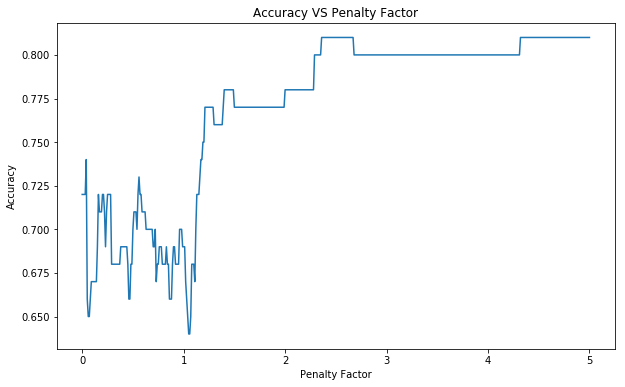

Penalty factor with best accuracy:  2.36
Corresponding accuracy:  0.81


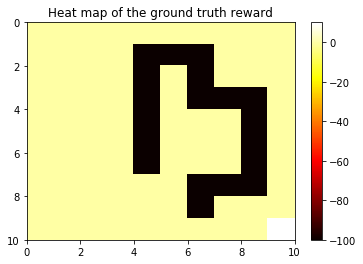

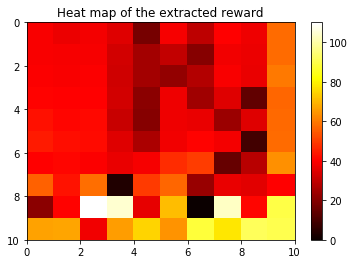

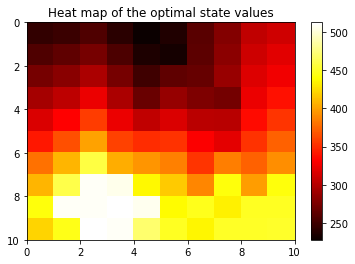

   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇨  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩  ⇨  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩  ⇩  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇨  ⇩
7  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇦  ⇦  ⇦  ⇨  ⇩  ⇩  ⇩
9  ⇨  ⇨  ⇧  ⇧  ⇦  ⇦  ⇨  ⇨  ⇩  ⇦


In [20]:
# plot the accuracy and penalty
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 5.01, 0.01), all_acc)
plt.xlabel('Penalty Factor')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Penalty Factor')
plt.show()

print('Penalty factor with best accuracy: ', IRL_best_penalty)
print('Corresponding accuracy: ', np.max(all_acc))
plot_heat_map(cur_reward, 'Heat map of the ground truth reward')
plot_heat_map(IRL_best_reward, 'Heat map of the extracted reward')
plot_heat_map(IRL_optimal_state_values, 'Heat map of the optimal state values')
print_optimal_policy_with_arrows(IRL_optimal_policy)

#### Q25

In [21]:
def print_arrows_discrepancy(optimal_policy_function,IRL_optimal_policy):
    
    optimal_policy_symbols = np.chararray((10, 10), unicode=True)
    arrow_symbols = ['⇧','⇩','⇦','⇨']
#     arrow_symbols = ['↑ ','↓ ','←','→ ']
#     arrow_symbols = ['\21E1','\u21E3','\u21E0','\u21E2']
    for i in range(4):
        optimal_policy_symbols[IRL_optimal_policy == i] = arrow_symbols[i]
    # mark difference
    optimal_policy_symbols[IRL_optimal_policy != optimal_policy_function] = '⥁ '
    print(pd.DataFrame(optimal_policy_symbols))

In [22]:
print_arrows_discrepancy(optimal_policy_function_2,IRL_optimal_policy)
print_optimal_policy_with_arrows(optimal_policy_function_2)
print_optimal_policy_with_arrows(IRL_optimal_policy)

   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⥁  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⥁  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⥁  ⇩  ⇩  ⥁  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⥁  ⇩  ⇩  ⥁  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⥁  ⇨  ⇩
7  ⥁  ⥁  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⥁  ⥁  ⥁  ⥁  ⇩  ⇩  ⇩
9  ⇨  ⇨  ⥁  ⥁  ⥁  ⥁  ⇨  ⇨  ⥁  ⥁
   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⇧  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇧  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇩  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇦  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇩
7  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩
   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇨  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩  ⇨  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩  ⇩  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇨  ⇩
7  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨ 